In [62]:
#必要情報をインポートする
"""

Graph based SLAM example

author: Atsushi Sakai (@Atsushi_twi)

Ref

[A Tutorial on Graph-Based SLAM]
(http://www2.informatik.uni-freiburg.de/~stachnis/pdf/grisetti10titsmag.pdf)

"""

import copy
import itertools
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as Rot

In [63]:
#  Simulation parameter
# diag : 対角行列の生成  https://note.nkmk.me/python-numpy-diag-diagonal/
Q_sim = np.diag([0.2, np.deg2rad(1.0)]) ** 2
R_sim = np.diag([0.1, np.deg2rad(10.0)]) ** 2


DT = 2.0  # time tick [s]　シミュレーション刻み
SIM_TIME = 100.0  # simulation time [s]
MAX_RANGE = 30.0  # maximum observation range
STATE_SIZE = 3  # State size [x,y,yaw]

# Covariance parameter of Graph Based SLAM
C_SIGMA1 = 0.1
C_SIGMA2 = 0.1
C_SIGMA3 = np.deg2rad(1.0)

MAX_ITR = 20  # Maximum iteration

show_graph_d_time = 20.0  # [s]
show_animation = True

In [64]:
#エッジのクラス生成　ノード間をつなぐもの
#1,2 があるのはおそらく始点と終点を指定するもの

class Edge:

    def __init__(self):
        #位置　x,y,w
        self.e = np.zeros((3, 1))
        """
        array([[0.],
               [0.],
               [0.]])
        """
        #精度行列
        self.omega = np.zeros((3, 3))  # information matrix
        """
        array([[0., 0., 0.],
               [0., 0., 0.],
               [0., 0., 0.]])
        """
        self.d1 = 0.0
        self.d2 = 0.0
        self.yaw1 = 0.0
        self.yaw2 = 0.0
        self.angle1 = 0.0
        self.angle2 = 0.0
        self.id1 = 0
        self.id2 = 0



In [65]:
def cal_observation_sigma():
    sigma = np.zeros((3, 3))
    sigma[0, 0] = C_SIGMA1 ** 2
    sigma[1, 1] = C_SIGMA2 ** 2
    sigma[2, 2] = C_SIGMA3 ** 2
    """
    array([[0.01      , 0.        , 0.        ],
           [0.        , 0.01      , 0.        ],
           [0.        , 0.        , 0.00030462]])
    """
    
    return sigma

In [66]:
#xyの回転行列　ｗは変化なし
def calc_rotational_matrix(angle):
    
    """
    Rt = np.matrix([[math.cos(angle), -math.sin(angle), 0],
                    [math.sin(angle), math.cos(angle), 0],
                    [0, 0, 1.0]])
    """
    
    return Rot.from_euler('z', angle).as_matrix()


In [87]:
#エッジの計算　単体
#x1, y1, yaw1　一つ目の位置オドメドリ　絶対座標
#x2, y2, yaw2　二つ目の位置オドメドリ　絶対座標
#ここから下は同じランドマークを見た場合に限る
#d1 angle1 : 同じランドマークを一つのオドメドリから見たランドマーク情報　距離　角度差（相対）
#d2 angle2 : 同じランドマークを2つのオドメドリから見たランドマーク情報　距離　角度差（相対）
#t1 一つ目のオドメドリの全体の配列内で何番目か
#t2 二つ目のオドメドリの全体の配列内で何番目か

def calc_edge(x1, y1, yaw1, x2, y2, yaw2, d1,
              angle1, d2, angle2, t1, t2):
    #エッジのクラス生成
    edge = Edge()
    #tangle1: オドメドリ角度(絶対角度)　+　角度差(相対角度)　＝　ランドマークの絶対角度（推定　誤差あり）
    #tangle2: オドメドリ角度(絶対角度)　+　角度差(相対角度)　＝　ランドマークの絶対角度（推定　誤差あり）
    tangle1 = pi_2_pi(yaw1 + angle1)
    tangle2 = pi_2_pi(yaw2 + angle2)
    
    #機台の向いている方向をX軸とした相対座標系において
    #tmp1：1つ目のオドメドリとランドマークのX成分
    tmp1 = d1 * math.cos(tangle1)
    #tmp2：2つ目のオドメドリとランドマークのX成分
    tmp2 = d2 * math.cos(tangle2)
    #tmp1：1つ目のオドメドリとランドマークのY成分
    tmp3 = d1 * math.sin(tangle1)
    #tmp1：2つ目のオドメドリとランドマークのY成分
    tmp4 = d2 * math.sin(tangle2)
    
    
    #エッジの誤差成分計算
    #    x 
    #e = y
    #    w
    
    #x2 - x1　　　　　両オドメドリの間のX軸上の距離
    #- tmp1 + tmp2　　同じランドマークから計算したX軸成分
    #もし誤差がないならば　　x2 - x1 - tmp1 + tmp2　＝　0
    #ちなみに絶対軸上での話
    edge.e[0, 0] = x2 - x1 - tmp1 + tmp2
    edge.e[1, 0] = y2 - y1 - tmp3 + tmp4
    #X,Y軸での話のため　角度は定義しない(厳密にいうとある？？)
    edge.e[2, 0] = 0

    #calc_rotational_matrix：　xyの回転行列　ｗは変化なし
    #オドメドリt1から見たランドマークの絶対角度の回転行列
    Rt1 = calc_rotational_matrix(tangle1)
    #オドメドリt2から見たランドマークの絶対角度の回転行列
    Rt2 = calc_rotational_matrix(tangle2)
    
    sig1 = cal_observation_sigma()
    sig2 = cal_observation_sigma()
    
    """
                                        array([[0.01      , 0.        , 0.        ],
    cal_observation_sigma()　 =　　　　　　   [0.        , 0.01      , 0.        ],
                                              [0.        , 0.        , 0.00030462]])

    """
    #行列の関算
    """

       Rt =     matrix([[11, 12, 13],
                        [21, 22, 23],
                        [31, 32, 33]])

       Rt.T =   matrix([[11, 21, 31],
                       [12, 22, 32],
                       [13, 23, 33]])

    """
    """
    #ここで重要なのは　Rt1 と　Rt2  ここの角度が大事
    #計算結果の逆両列が　精度行列　　その前は共分散行列
    """
    edge.omega = np.linalg.inv(Rt1 @ sig1 @ Rt1.T + Rt2 @ sig2 @ Rt2.T)
    
    #残りはそのまま
    edge.d1, edge.d2 = d1, d2
    edge.yaw1, edge.yaw2 = yaw1, yaw2
    edge.angle1, edge.angle2 = angle1, angle2
    edge.id1, edge.id2 = t1, t2

    return edge

In [68]:
#すべてのエッジを計算
"""
引数：オドメドリ　x_list　
   ランドマーク　　z_list
"""
def calc_edges(x_list, z_list):
    #エッジの宣言
    edges = []
    #コストの変数宣言
    cost = 0.0
#itertools.combinations(iterable, r)
#入力 iterable の要素からなる長さ r の部分列を返します。 https://docs.python.org/ja/3/library/itertools.html#itertools.combinations
    z_ids = list(itertools.combinations(range(len(z_list)), 2))

    """
    10
range(0, 10)
<itertools.combinations object at 0x0000021905A85598>
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), 
(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), 
(2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), 
(3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), 
(4, 5), (4, 6), (4, 7), (4, 8), (4, 9), 
(5, 6), (5, 7), (5, 8), (5, 9), 
(6, 7), (6, 8), (6, 9), 
(7, 8), (7, 9), 
(8, 9)]
    """
    
    for (t1, t2) in z_ids:
        #X_list  オドメドリ（誤差あり）
        #10個のオドメドリの組み合わせ（重複なし）
        x1, y1, yaw1 = x_list[0, t1], x_list[1, t1], x_list[2, t1]
        x2, y2, yaw2 = x_list[0, t2], x_list[1, t2], x_list[2, t2]
        
        #ランドマーク情報がない場合、何もしない。
        if z_list[t1] is None or z_list[t2] is None:
            continue  # No observation
        #ランドマークがある場合
        """
         ランドマーク情報(dn:機台かランドマークまでの距離, 　　　　　　0
                         angle：機台角度とランドマークの角度の角度差, 　1
                         phi:機台から見たランドマークの角度　　　　　　2
                         i:何番目のランドマークか)　　　　　　　　　　　3　　　
        """
        #dn:機台かランドマークまでの距離　ここマジ大事
        #[:, 0]行がある限り表示　表示するのは0列目　　補足[0,:] 列がある限り表示　表示するのは0行目
        #len(z_list[t1][:, 0]　　t1番目の位置で見えた欄マークの数
        for iz1 in range(len(z_list[t1][:, 0])):
            #len(z_list[t2][:, 0]　　t2番目の位置で見えた欄マークの数
            for iz2 in range(len(z_list[t2][:, 0])):
                #もし　t1 番目の位置で見えたiz1 番目のランドマークのIDが　
                #　　　t2 番目の位置で見えたiz2番目のランドマークのIDと同じならば
                if z_list[t1][iz1, 3] == z_list[t2][iz2, 3]:
                    #それぞれのオドメドリから同じランドマークまでの距離、角度差、絶対角度を抽出
                    d1 = z_list[t1][iz1, 0]
                    angle1, phi1 = z_list[t1][iz1, 1], z_list[t1][iz1, 2]
                    d2 = z_list[t2][iz2, 0]
                    angle2, phi2 = z_list[t2][iz2, 1], z_list[t2][iz2, 2]
                    
                    #t1 と　t2 のエッジを計算する
                    edge = calc_edge(x1, y1, yaw1, x2, y2, yaw2, d1,
                                     angle1, d2, angle2, t1, t2)
                    #エッジ情報を代入
                    edges.append(edge)
                    
                    #一つでもエッジが更新されたらコスト再計算
                    #行列計算　[1*3] @ [3*3] @ [3*1] = [1*1]
                    #最終的に一つの値になる
                    cost += (edge.e.T @ edge.omega @ edge.e)[0, 0]

    print("cost:", cost, ",n_edge:", len(edges))
    return edges

In [69]:
#ヤコビ行列の計算
def calc_jacobian(edge):
    #そのエッジの始点の角度（絶対座標）+　角度さ（相対）　＝　エッジの方向をX軸としたランドマークの角度　t1
    t1 = edge.yaw1 + edge.angle1
    A = np.array([[-1.0, 0, edge.d1 * math.sin(t1)],
                  [0, -1.0, -edge.d1 * math.cos(t1)],
                  [0, 0, 0]])

    t2 = edge.yaw2 + edge.angle2
    B = np.array([[1.0, 0, -edge.d2 * math.sin(t2)],
                  [0, 1.0, edge.d2 * math.cos(t2)],
                  [0, 0, 0]])

    return A, B

In [70]:
#おそらく最適化の計算
#H,b　不明
# edge  各エッジ　1個ずつ
def fill_H_and_b(H, b, edge):
    #ヤコビ行列
    A, B = calc_jacobian(edge)
    
    id1 = edge.id1 * STATE_SIZE
    id2 = edge.id2 * STATE_SIZE

    H[id1:id1 + STATE_SIZE, id1:id1 + STATE_SIZE] += A.T @ edge.omega @ A
    H[id1:id1 + STATE_SIZE, id2:id2 + STATE_SIZE] += A.T @ edge.omega @ B
    H[id2:id2 + STATE_SIZE, id1:id1 + STATE_SIZE] += B.T @ edge.omega @ A
    H[id2:id2 + STATE_SIZE, id2:id2 + STATE_SIZE] += B.T @ edge.omega @ B

    b[id1:id1 + STATE_SIZE] += (A.T @ edge.omega @ edge.e)
    b[id2:id2 + STATE_SIZE] += (B.T @ edge.omega @ edge.e)

    return H, b

In [71]:
"""
 引数　オドメドリ　
 ランドマーク情報(dn:機台かランドマークまでの距離, 
                 angle：機台角度とランドマークの角度の角度差, 
                 phi:機台から見たランドマークの角度
                 i:何番目のランドマークか)
"""
def graph_based_slam(x_init, hz):
    print("start graph based slam")
    
    #ランドマークリストをコピー　https://qiita.com/Kaz_K/items/a3d619b9e670e689b6db
    #hzが変わっても　Z_listは変わらない。　いわゆる別の変数にして使っている。
    z_list = copy.deepcopy(hz)
    #位置情報をコピー　上に同じ
    x_opt = copy.deepcopy(x_init)
    #print("debapgu1",x_opt)
    #配列1番目の個数を表示
    nt = x_opt.shape[1]
    #print("debapgu2",nt)
    #その個数に3倍（次元の数だけ）
    n = nt * STATE_SIZE
    #print("debapgu2",n)
    
    #最適化処理
    # MAX_ITR = 20　　最高計算回数
    for itr in range(MAX_ITR):
        """
        引数：オドメドリ
        　　　ランドマーク
        """
        edges = calc_edges(x_opt, z_list)
        #全エッジを取得
        
        #[30*30]のゼロ行列
        H = np.zeros((n, n))
        #[30*1]のゼロ行列
        b = np.zeros((n, 1))

        for edge in edges:
            H, b = fill_H_and_b(H, b, edge)

        # to fix origin
        H[0:STATE_SIZE, 0:STATE_SIZE] += np.identity(STATE_SIZE)

        dx = - np.linalg.inv(H) @ b

        for i in range(nt):
            x_opt[0:3, i] += dx[i * 3:i * 3 + 3, 0]

        diff = dx.T @ dx
        print("iteration: %d, diff: %f" % (itr + 1, diff))
        #必要な精度いかになったら終了
        if diff < 1.0e-5:
            break

    return x_opt

In [72]:
#車両の速度と角度
def calc_input():
    v = 1.0  # [m/s]
    yaw_rate = 0.1  # [rad/s]
    u = np.array([[v, yaw_rate]]).T
    """
    array([[1. ],
           [0.1]])
    """
    return u

In [73]:
#引数：　真値　オドメドリ　車両走行情報　ランドマーク
def observation(xTrue, xd, u, RFID):
    #真値計算　引き値：　位置　車両走行情報
    xTrue = motion_model(xTrue, u)

    # add noise to gps x-y
    z = np.zeros((0, 4))

    for i in range(len(RFID[:, 0])):

        dx = RFID[i, 0] - xTrue[0, 0]
        dy = RFID[i, 1] - xTrue[1, 0]
        d = math.hypot(dx, dy)
        angle = pi_2_pi(math.atan2(dy, dx)) - xTrue[2, 0]
        phi = pi_2_pi(math.atan2(dy, dx))
        if d <= MAX_RANGE:
            dn = d + np.random.randn() * Q_sim[0, 0]  # add noise
            angle_noise = np.random.randn() * Q_sim[1, 1]
            angle += angle_noise
            phi += angle_noise
            zi = np.array([dn, angle, phi, i])
            z = np.vstack((z, zi))

    # add noise to input
    ud1 = u[0, 0] + np.random.randn() * R_sim[0, 0]
    ud2 = u[1, 0] + np.random.randn() * R_sim[1, 1]
    ud = np.array([[ud1, ud2]]).T

    xd = motion_model(xd, ud)

    return xTrue, z, xd, ud

In [74]:
#車両の動作モデル　引き値：　位置　車両走行情報
def motion_model(x, u):
    #3*3　の単位行列
    F = np.array([[1.0, 0, 0],
                  [0, 1.0, 0],
                  [0, 0, 1.0]])
    
    #車両の位置及び角度情報　シミュレーション刻み：DT
    #x[2, 0]　威勢の　角度　[0,0] :x   [1,0]:y
    B = np.array([[DT * math.cos(x[2, 0]), 0],
                  [DT * math.sin(x[2, 0]), 0],
                  [0.0, DT]])

    x = F @ x + B @ u

    return x

In [75]:
def pi_2_pi(angle):
    return (angle + math.pi) % (2 * math.pi) - math.pi

__file__ start!!
start graph based slam
cost: 7181.072652832521 ,n_edge: 225
iteration: 1, diff: 0.678992
cost: 38.87373967044607 ,n_edge: 225
iteration: 2, diff: 0.006866
cost: 37.582910887438516 ,n_edge: 225
iteration: 3, diff: 0.000018
cost: 37.58289753599207 ,n_edge: 225
iteration: 4, diff: 0.000000


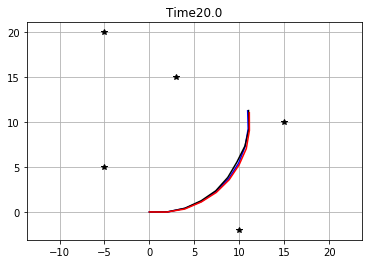

start graph based slam
cost: 218739.68056289328 ,n_edge: 950
iteration: 1, diff: 61.407402
cost: 732.3495836424883 ,n_edge: 950
iteration: 2, diff: 0.460123
cost: 132.61095270034699 ,n_edge: 950
iteration: 3, diff: 0.002721
cost: 132.60535443952293 ,n_edge: 950
iteration: 4, diff: 0.000031
cost: 132.60534626669306 ,n_edge: 950
iteration: 5, diff: 0.000000


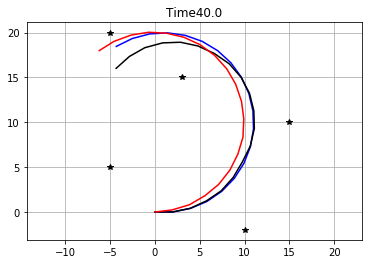

start graph based slam
cost: 565741.407432094 ,n_edge: 2175
iteration: 1, diff: 211.856667
cost: 1563.3867097375146 ,n_edge: 2175
iteration: 2, diff: 0.329436
cost: 285.48020487354535 ,n_edge: 2175
iteration: 3, diff: 0.000430
cost: 285.4799365111902 ,n_edge: 2175
iteration: 4, diff: 0.000006


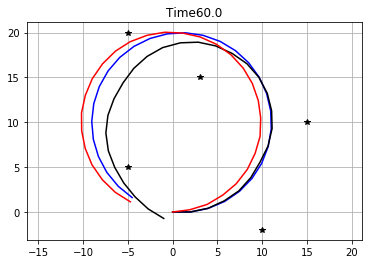

start graph based slam
cost: 918437.7088115506 ,n_edge: 3900
iteration: 1, diff: 347.666180
cost: 2447.9624137056385 ,n_edge: 3900
iteration: 2, diff: 0.356558
cost: 493.5096358050289 ,n_edge: 3900
iteration: 3, diff: 0.000085
cost: 493.5095760662217 ,n_edge: 3900
iteration: 4, diff: 0.000001


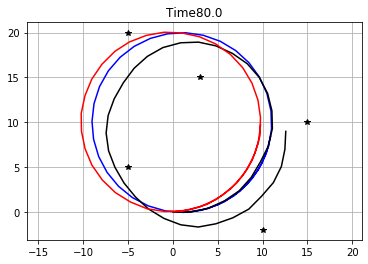

start graph based slam
cost: 1330928.2682878273 ,n_edge: 6125
iteration: 1, diff: 423.585811
cost: 3575.500366031588 ,n_edge: 6125
iteration: 2, diff: 0.460052
cost: 762.9252074698294 ,n_edge: 6125
iteration: 3, diff: 0.000047
cost: 762.9251741751565 ,n_edge: 6125
iteration: 4, diff: 0.000001


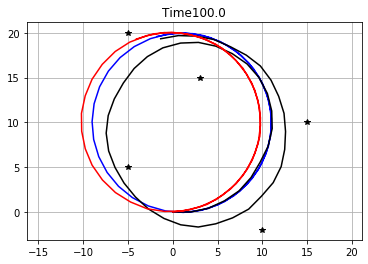

In [76]:
def main():
    print("__file__" + " start!!")

    time = 0.0

    #ランドマーク
    # RFID positions [x, y, yaw]
    RFID = np.array([[10.0, -2.0, 0.0],
                     [15.0, 10.0, 0.0],
                     [3.0, 15.0, 0.0],
                     [-5.0, 20.0, 0.0],
                     [-5.0, 5.0, 0.0]
                     ])
    
    #STATE_SIZE　=　3　姿勢は3次元
    # State Vector [x y yaw v]'
    xTrue = np.zeros((STATE_SIZE, 1)) #真値
    xDR = np.zeros((STATE_SIZE, 1))  # Dead reckoning

    #履歴
    # history
    hxTrue = []
    hxDR = []
    hz = []
    d_time = 0.0
    init = False
    
    while SIM_TIME >= time:

        #初期化設定
        if not init:
            #初回の履歴に真値を代入
            hxTrue = xTrue
            hxDR = xTrue
            init = True
            
        else:
            #オドメドリを前回値に横に結合　https://deepage.net/features/numpy-stack.html
            hxDR = np.hstack((hxDR, xDR))
            hxTrue = np.hstack((hxTrue, xTrue))

        time += DT
        d_time += DT
        #車両の走行情報
        u = calc_input()
        
        #引数：　真値　オドメドリ　車両走行情報　ランドマーク
        #戻り値　：　真値　ランドマーク情報（その周期で観測したもののみ）　オドメドリ（誤差あり）　車両の移動ベクトル(誤差あり）
        xTrue, z, xDR, ud = observation(xTrue, xDR, u, RFID)
        
        #ランドマーク情報を追加　リスト型
        hz.append(z)

        #時間の刻みが一定期間超えたらグラフSLAMを行う。
        if d_time >= show_graph_d_time:
            """
             引数　オドメドリ
             
             ランドマーク情報(dn:機台かランドマークまでの距離, 
                             angle：機台角度とランドマークの角度の角度差, 
                             phi:機台から見たランドマークの角度
                             i:何番目のランドマークか)
            """
           
            x_opt = graph_based_slam(hxDR, hz)
            d_time = 0.0

            if show_animation:  # pragma: no cover
                plt.cla()
                # for stopping simulation with the esc key.
                plt.gcf().canvas.mpl_connect(
                    'key_release_event',
                    lambda event: [exit(0) if event.key == 'escape' else None])
                plt.plot(RFID[:, 0], RFID[:, 1], "*k")

                plt.plot(hxTrue[0, :].flatten(),
                         hxTrue[1, :].flatten(), "-b")
                plt.plot(hxDR[0, :].flatten(),
                         hxDR[1, :].flatten(), "-k")
                plt.plot(x_opt[0, :].flatten(),
                         x_opt[1, :].flatten(), "-r")
                plt.axis("equal")
                plt.grid(True)
                plt.title("Time" + str(time)[0:5])
                plt.pause(1.0)


if __name__ == '__main__':
    main()

In [36]:
v = 1.0  # [m/s]
yaw_rate = 0.1  # [rad/s]
u = np.array([[v, yaw_rate]]).T
u

array([[1. ],
       [0.1]])

In [37]:
z = np.zeros((0, 4))
z

array([], shape=(0, 4), dtype=float64)

In [39]:
print(z)

[]


In [4]:
z = np.array([5,2,3,4])
zi = np.array([1,2,3,4])
z = np.vstack((z, zi))
z

array([[5, 2, 3, 4],
       [1, 2, 3, 4]])

In [5]:
hz=[]
hz

[]

In [8]:
hz.append(z)

In [11]:
hz[1]

array([[5, 2, 3, 4],
       [1, 2, 3, 4]])

In [12]:
 z_list = copy.deepcopy(hz)

In [15]:
z_list.shape[1]


AttributeError: 'list' object has no attribute 'shape'

AttributeError: 'list' object has no attribute 'T'

In [19]:
z_list

[[1, 2]]

In [47]:
range(10)

range(0, 10)

In [48]:
for i in range(10):
    print(i)

0
1
2
3
4
5
6
7
8
9


In [49]:
list(itertools.combinations(range(0,10), 3))

[(0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (0, 1, 8),
 (0, 1, 9),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 2, 6),
 (0, 2, 7),
 (0, 2, 8),
 (0, 2, 9),
 (0, 3, 4),
 (0, 3, 5),
 (0, 3, 6),
 (0, 3, 7),
 (0, 3, 8),
 (0, 3, 9),
 (0, 4, 5),
 (0, 4, 6),
 (0, 4, 7),
 (0, 4, 8),
 (0, 4, 9),
 (0, 5, 6),
 (0, 5, 7),
 (0, 5, 8),
 (0, 5, 9),
 (0, 6, 7),
 (0, 6, 8),
 (0, 6, 9),
 (0, 7, 8),
 (0, 7, 9),
 (0, 8, 9),
 (1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (1, 2, 6),
 (1, 2, 7),
 (1, 2, 8),
 (1, 2, 9),
 (1, 3, 4),
 (1, 3, 5),
 (1, 3, 6),
 (1, 3, 7),
 (1, 3, 8),
 (1, 3, 9),
 (1, 4, 5),
 (1, 4, 6),
 (1, 4, 7),
 (1, 4, 8),
 (1, 4, 9),
 (1, 5, 6),
 (1, 5, 7),
 (1, 5, 8),
 (1, 5, 9),
 (1, 6, 7),
 (1, 6, 8),
 (1, 6, 9),
 (1, 7, 8),
 (1, 7, 9),
 (1, 8, 9),
 (2, 3, 4),
 (2, 3, 5),
 (2, 3, 6),
 (2, 3, 7),
 (2, 3, 8),
 (2, 3, 9),
 (2, 4, 5),
 (2, 4, 6),
 (2, 4, 7),
 (2, 4, 8),
 (2, 4, 9),
 (2, 5, 6),
 (2, 5, 7),
 (2, 5, 8),
 (2, 5, 9),
 (2, 6, 7),
 (2, 6, 8),
 (2, 6, 9),
 (2, 7, 8),
 (2,

In [53]:
    Rt = np.matrix([[11, 12, 13],
                    [21, 22, 23],
                    [31, 32, 33]])

In [54]:
Rt

matrix([[11, 12, 13],
        [21, 22, 23],
        [31, 32, 33]])

In [55]:
Rt.T

matrix([[11, 21, 31],
        [12, 22, 32],
        [13, 23, 33]])

In [56]:
def calc_rotational_matrix(angle):
    
    """
    Rt = np.matrix([[math.cos(angle), -math.sin(angle), 0],
                    [math.sin(angle), math.cos(angle), 0],
                    [0, 0, 1.0]])
    """
    
    return Rot.from_euler('z', angle).as_matrix()

In [57]:
a = calc_rotational_matrix(45)

In [58]:
a

array([[ 0.52532199, -0.85090352, -0.        ],
       [ 0.85090352,  0.52532199,  0.        ],
       [ 0.        , -0.        ,  1.        ]])

In [60]:
3980*2*1.1-2200

6556.0